# Data visualisation

In [29]:
# Import necessary libraries

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [30]:
# Input size (should match the input size used during training)
input_size = 224

# Data transformations (should be the same as used during training)
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [31]:
# Path to your dataset (update if necessary)
data_dir = 'processed_dataset'

# Create the validation dataset
image_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

# Create DataLoader
dataloader = DataLoader(image_dataset, batch_size=32, shuffle=False, num_workers=4)

# Get class names
class_names = image_dataset.classes
print(f'Classes: {class_names}')


Classes: ['step_1', 'step_2_Left', 'step_2_Right', 'step_3', 'step_4_Left', 'step_4_Right', 'step_5_Left', 'step_5_Right', 'step_6_Left', 'step_6_Right']


## MobileNetv2 testing

In [32]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    if model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=use_pretrained)
        # Change the final layer
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "mobilenet_v3_large":
        model = models.mobilenet_v3_large(pretrained=use_pretrained)
        # Change the final layer
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
    else:
        print("Invalid model name, exiting...")
        exit()
    return model

# Specify the model to use
model_name = "mobilenet_v2"

# Number of classes
num_classes = len(class_names)

# Initialize the model
model_ft = initialize_model(model_name, num_classes, use_pretrained=False)

# Load the trained model weights
model_path = f'{model_name}_handwash.pth'  # Update the path if necessary
model_ft.load_state_dict(torch.load(model_path, map_location=device))

# Move model to device
model_ft = model_ft.to(device)

# Set model to evaluation mode
model_ft.eval()


C:\Users\msila\AppData\Local\Temp\ipykernel_19732\2189745462.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(model_path, map_locatio

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [33]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_model(model, dataloader, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidences, preds = torch.max(probabilities, 1)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                confidence = confidences[i].item() * 100  # Convert to percentage
                class_name = class_names[preds[i]]
                true_class = class_names[labels[i]]
                plt.figure(figsize=(5, 5))
                imshow(inputs.cpu().data[i], title=f'Predicted: {class_name} ({confidence:.2f}%)\nTrue: {true_class}')
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


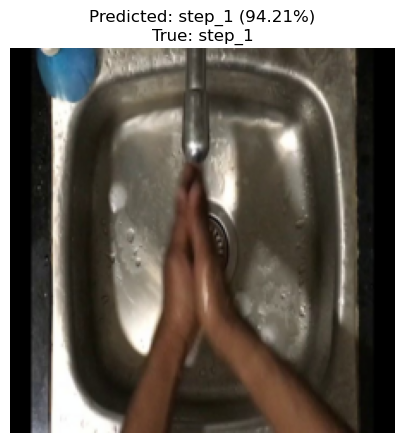

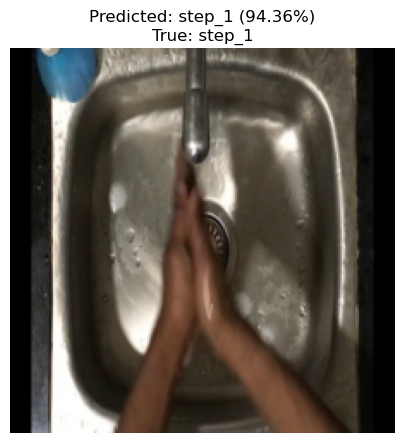

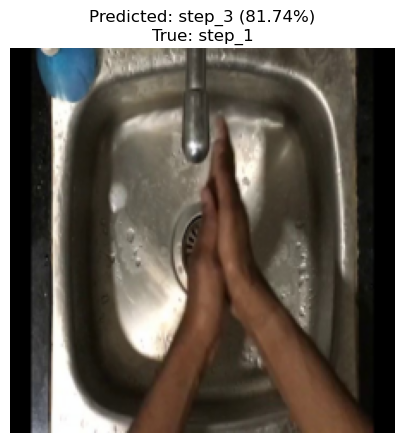

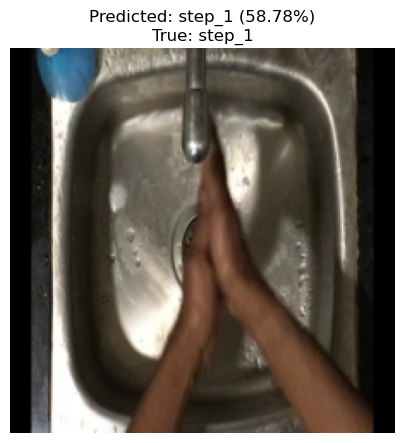

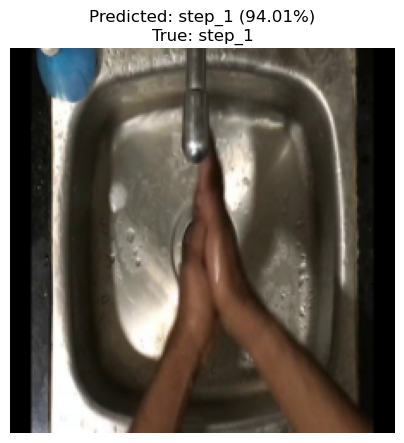

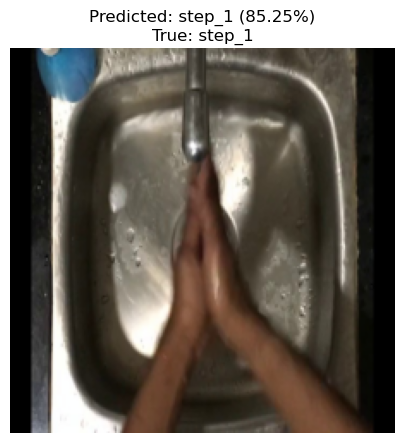

In [34]:
# Call the function to visualize predictions
visualize_model(model_ft, dataloader, class_names)

In [35]:
def predict_single_image(model, image_path, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    transform = data_transforms['val']
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        # Get the predicted class index and confidence
        confidence, pred = torch.max(probabilities, 0)
        class_name = class_names[pred.item()]
        confidence = confidence.item() * 100  # Convert to percentage

    # Show image and prediction with confidence score
    plt.figure(figsize=(5, 5))
    imshow(image.cpu().squeeze(), title=f'Predicted: {class_name}\nConfidence: {confidence:.2f}%')

def predict_single_image_topk(model, image_path, class_names, topk=3):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    transform = data_transforms['val']
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        # Get the top K predictions
        confidences, preds = torch.topk(probabilities, topk)
        confidences = confidences.cpu().numpy()
        preds = preds.cpu().numpy()
        class_preds = [class_names[pred] for pred in preds]
        confidences = confidences * 100  # Convert to percentages

    # Show image
    plt.figure(figsize=(5, 5))
    imshow(image.cpu().squeeze(), title='Top Predictions')
    
    # Print top K predictions with confidence scores
    for i in range(topk):
        print(f"Prediction {i+1}: {class_preds[i]} - Confidence: {confidences[i]:.2f}%")


### Comparisons

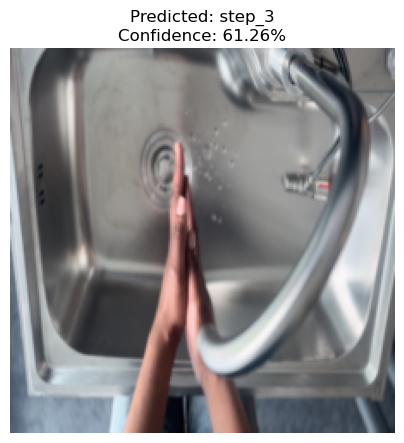

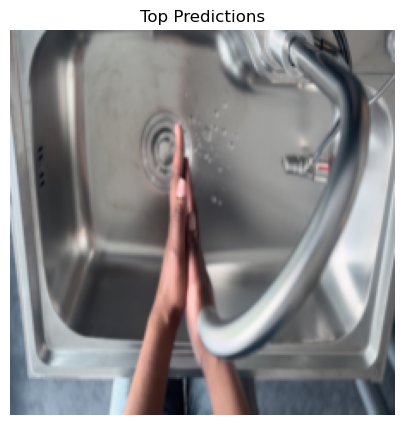

Prediction 1: step_3 - Confidence: 61.26%
Prediction 2: step_1 - Confidence: 38.72%
Prediction 3: step_5_Right - Confidence: 0.01%


In [37]:
# Test the model on a new image
test_image_path = './processed_dataset/manual_test/1/IMG_3411.jpg'  

predict_single_image(model_ft, test_image_path, class_names)
predict_single_image_topk(model_ft, test_image_path, class_names, topk=3)


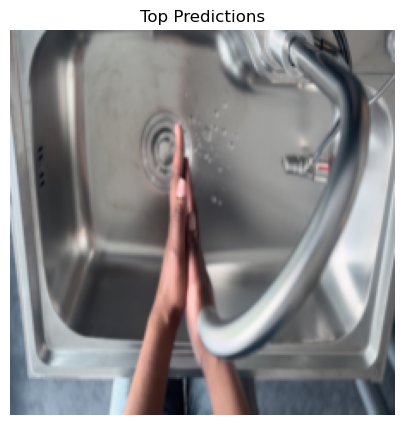

Prediction 1: step_3 - Confidence: 61.26%
Prediction 2: step_1 - Confidence: 38.72%
Prediction 3: step_5_Right - Confidence: 0.01%


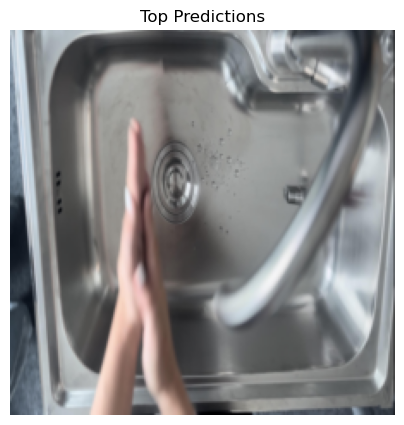

Prediction 1: step_1 - Confidence: 92.60%
Prediction 2: step_3 - Confidence: 5.56%
Prediction 3: step_5_Right - Confidence: 0.90%


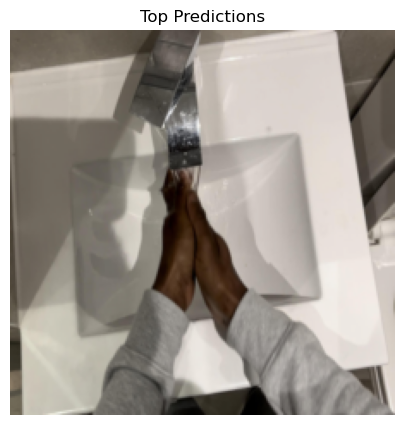

Prediction 1: step_1 - Confidence: 76.58%
Prediction 2: step_5_Right - Confidence: 16.12%
Prediction 3: step_3 - Confidence: 6.19%


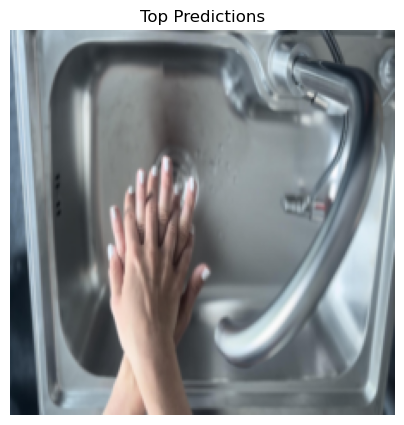

Prediction 1: step_1 - Confidence: 75.67%
Prediction 2: step_2_Right - Confidence: 8.84%
Prediction 3: step_6_Right - Confidence: 6.18%


In [38]:
# Test the model on a new image
test_image_path = './processed_dataset/manual_test/1/IMG_3411.jpg'  
predict_single_image_topk(model_ft, test_image_path, class_names, topk=3)

test_image_path1 = './processed_dataset/manual_test/1/1.jpg'  
predict_single_image_topk(model_ft, test_image_path1, class_names, topk=3)

test_image_path2 = './processed_dataset/manual_test/1/2.jpg'  
predict_single_image_topk(model_ft, test_image_path2, class_names, topk=3)

test_image_path3 = './processed_dataset/manual_test/2r/1.jpg'  
predict_single_image_topk(model_ft, test_image_path3, class_names, topk=3)

## Mobilenetv3 Large testing

In [39]:
# Specify the model to use
model_name = "mobilenet_v3_large"

# Number of classes
num_classes = len(class_names)

# Initialize the model
model_ft = initialize_model(model_name, num_classes, use_pretrained=False)

# Load the trained model weights
model_path = f'{model_name}_handwash.pth'  # Update the path if necessary
model_ft.load_state_dict(torch.load(model_path, map_location=device))

# Move model to device
model_ft = model_ft.to(device)

# Set model to evaluation mode
model_ft.eval()

c:\Users\msila\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\msila\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\msila\AppData\Local\Temp\ipykernel_19732\2287428279.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weigh

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

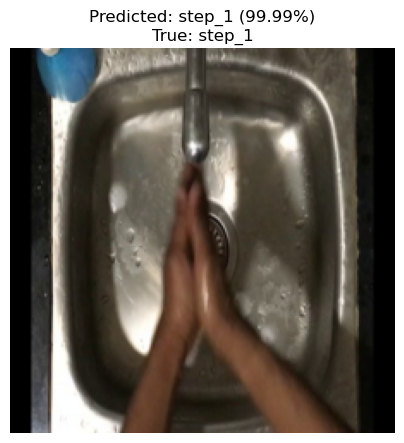

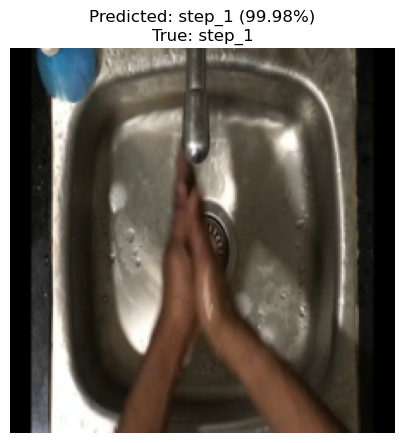

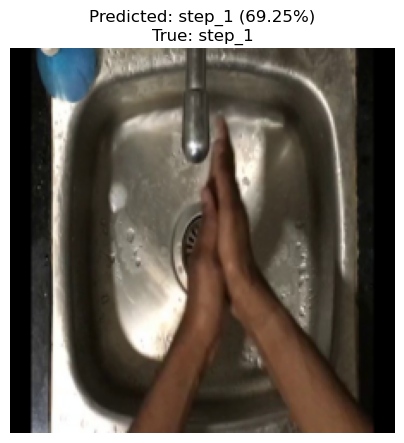

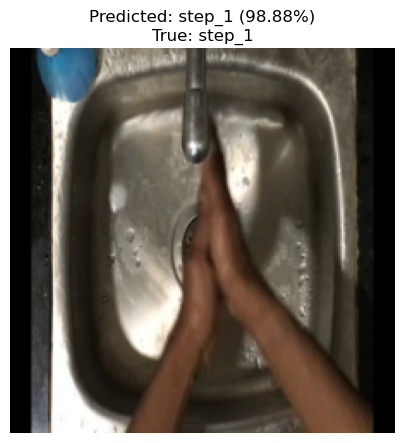

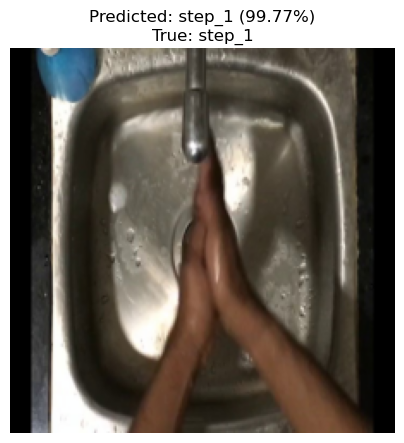

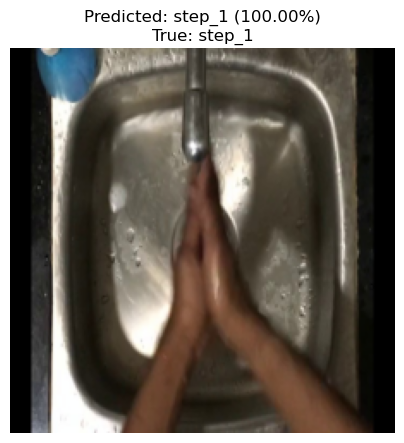

In [40]:
# Call the function to visualize predictions
visualize_model(model_ft, dataloader, class_names)

### Comparisons

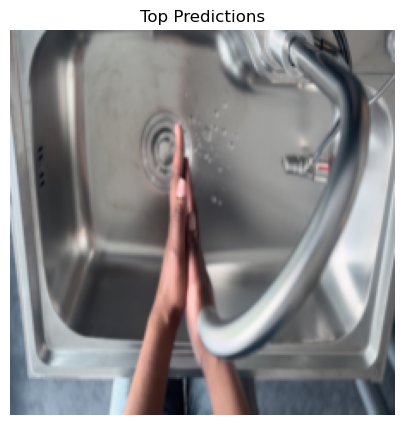

Prediction 1: step_3 - Confidence: 82.62%
Prediction 2: step_1 - Confidence: 17.15%
Prediction 3: step_5_Right - Confidence: 0.11%


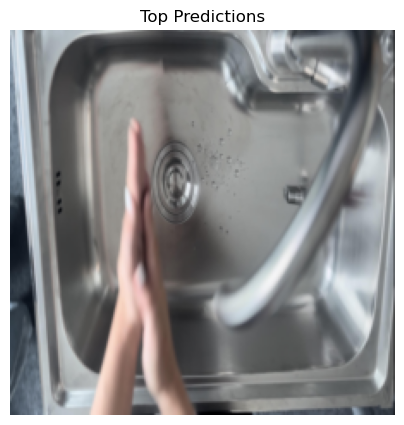

Prediction 1: step_3 - Confidence: 55.97%
Prediction 2: step_1 - Confidence: 43.93%
Prediction 3: step_4_Right - Confidence: 0.04%


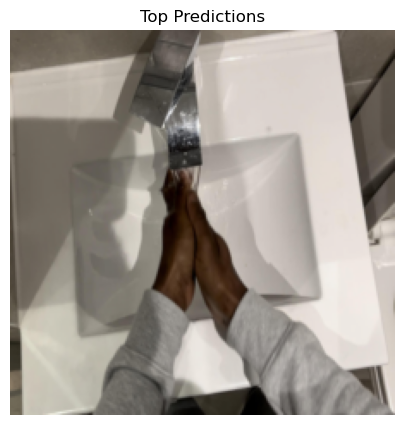

Prediction 1: step_3 - Confidence: 56.36%
Prediction 2: step_4_Right - Confidence: 16.82%
Prediction 3: step_1 - Confidence: 7.45%


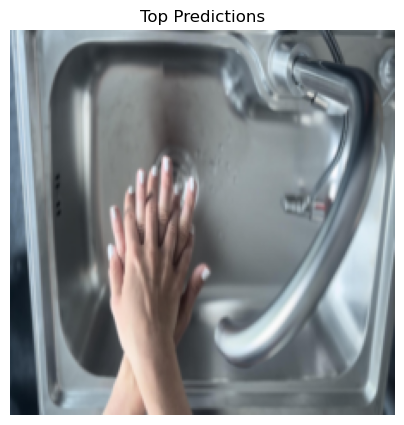

Prediction 1: step_2_Right - Confidence: 99.55%
Prediction 2: step_1 - Confidence: 0.25%
Prediction 3: step_2_Left - Confidence: 0.13%


In [41]:
# Test the model on a new image
test_image_path = './processed_dataset/manual_test/1/IMG_3411.jpg'  
predict_single_image_topk(model_ft, test_image_path, class_names, topk=3)

test_image_path1 = './processed_dataset/manual_test/1/1.jpg'  
predict_single_image_topk(model_ft, test_image_path1, class_names, topk=3)

test_image_path2 = './processed_dataset/manual_test/1/2.jpg'  
predict_single_image_topk(model_ft, test_image_path2, class_names, topk=3)

test_image_path3 = './processed_dataset/manual_test/2r/1.jpg'  
predict_single_image_topk(model_ft, test_image_path3, class_names, topk=3)

## MobileNetv2 feature extraction testing

In [43]:
# Specify the model to use
model_name = "mobilenet_v2"

# Number of classes
num_classes = len(class_names)

# Initialize the model
model_ft = initialize_model(model_name, num_classes, use_pretrained=False)

# Load the trained model weights
model_path = f'{model_name}_fe_handwash.pth'  # Update the path if necessary
model_ft.load_state_dict(torch.load(model_path, map_location=device))

# Move model to device
model_ft = model_ft.to(device)

# Set model to evaluation mode
model_ft.eval()

C:\Users\msila\AppData\Local\Temp\ipykernel_19732\3423934658.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(model_path, map_locatio

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

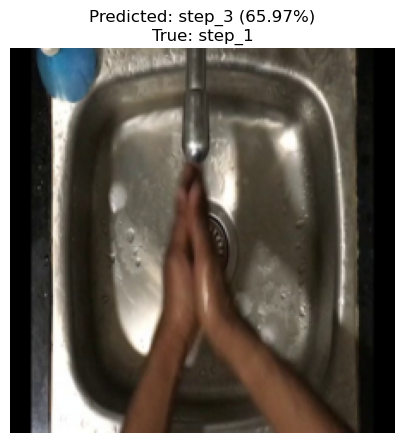

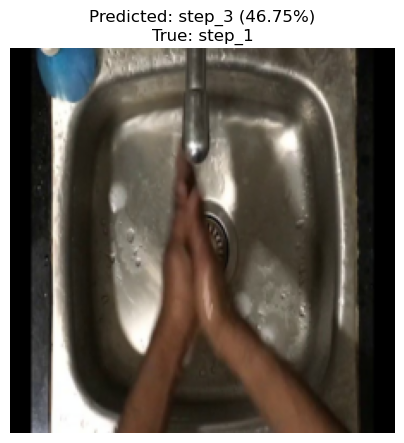

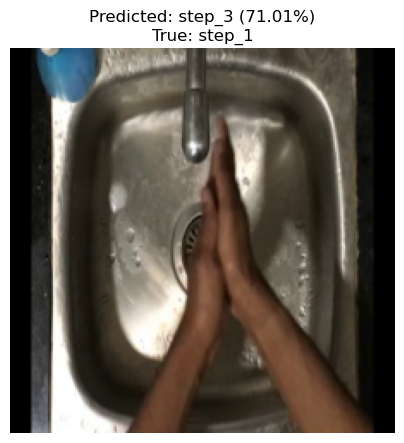

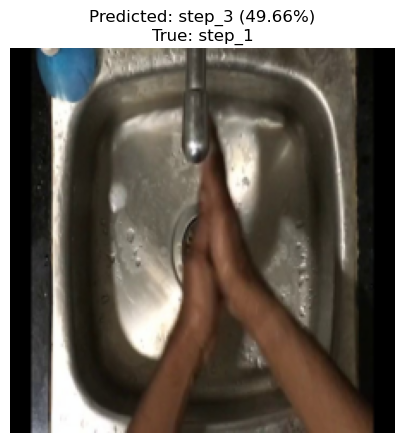

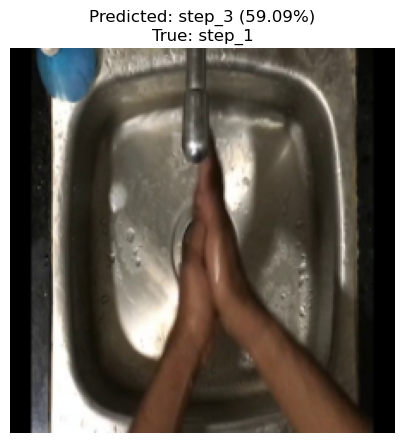

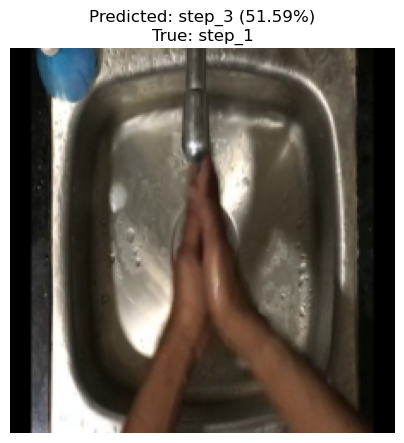

In [44]:
# Call the function to visualize predictions
visualize_model(model_ft, dataloader, class_names)

### Comparisons

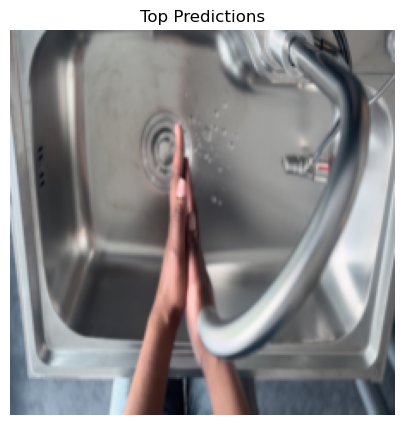

Prediction 1: step_3 - Confidence: 59.38%
Prediction 2: step_1 - Confidence: 22.89%
Prediction 3: step_5_Left - Confidence: 5.07%


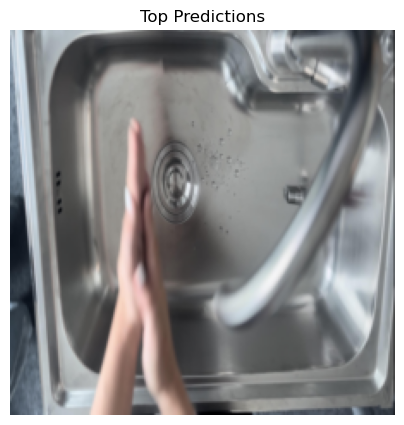

Prediction 1: step_3 - Confidence: 57.38%
Prediction 2: step_1 - Confidence: 25.82%
Prediction 3: step_2_Left - Confidence: 5.91%


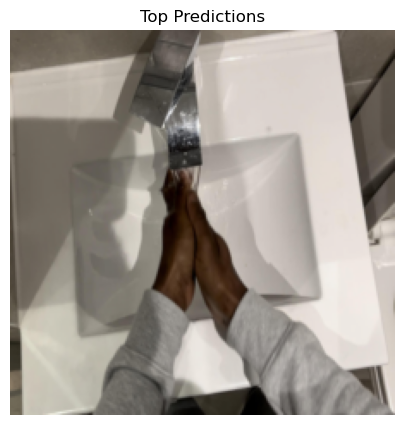

Prediction 1: step_3 - Confidence: 57.73%
Prediction 2: step_6_Left - Confidence: 27.42%
Prediction 3: step_5_Left - Confidence: 4.33%


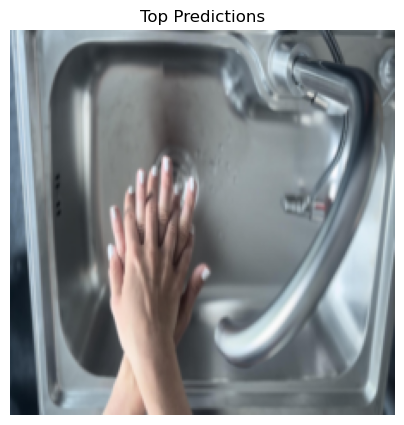

Prediction 1: step_2_Right - Confidence: 41.14%
Prediction 2: step_2_Left - Confidence: 22.92%
Prediction 3: step_1 - Confidence: 9.11%


In [45]:
# Test the model on a new image
test_image_path = './processed_dataset/manual_test/1/IMG_3411.jpg'  
predict_single_image_topk(model_ft, test_image_path, class_names, topk=3)

test_image_path1 = './processed_dataset/manual_test/1/1.jpg'  
predict_single_image_topk(model_ft, test_image_path1, class_names, topk=3)

test_image_path2 = './processed_dataset/manual_test/1/2.jpg'  
predict_single_image_topk(model_ft, test_image_path2, class_names, topk=3)

test_image_path3 = './processed_dataset/manual_test/2r/1.jpg'  
predict_single_image_topk(model_ft, test_image_path3, class_names, topk=3)

## MobileNetv2 feature extraction testing with 25 epochs

In [46]:
# Specify the model to use
model_name = "mobilenet_v2"

# Number of classes
num_classes = len(class_names)

# Initialize the model
model_ft = initialize_model(model_name, num_classes, use_pretrained=False)

# Load the trained model weights
model_path = f'{model_name}_fe_25_handwash.pth'  # Update the path if necessary
model_ft.load_state_dict(torch.load(model_path, map_location=device))

# Move model to device
model_ft = model_ft.to(device)

# Set model to evaluation mode
model_ft.eval()

C:\Users\msila\AppData\Local\Temp\ipykernel_19732\3055627265.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(model_path, map_locatio

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

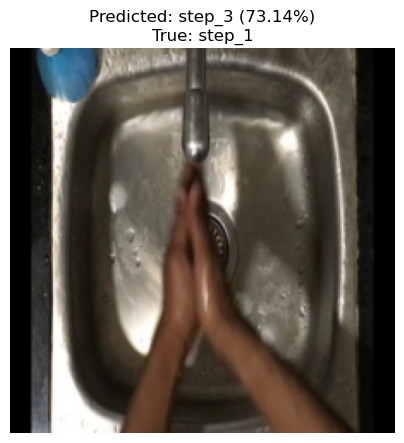

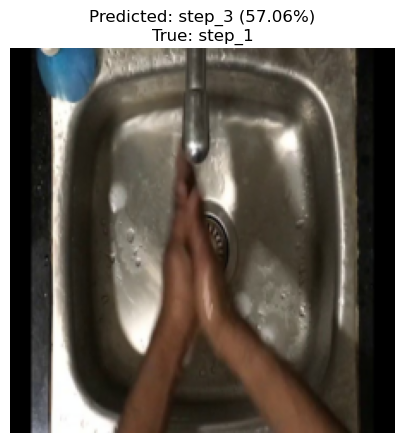

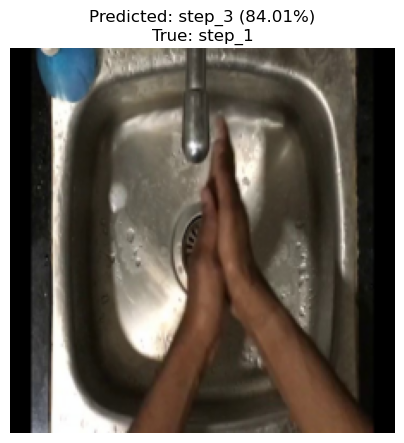

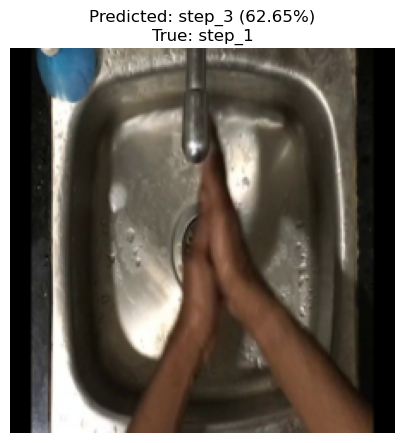

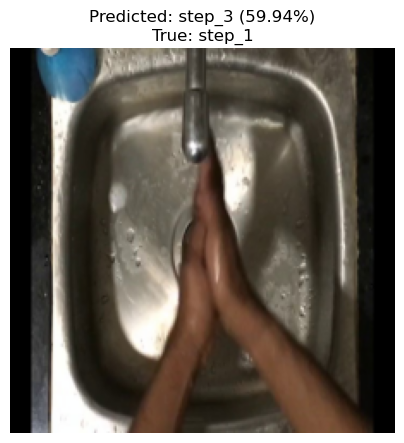

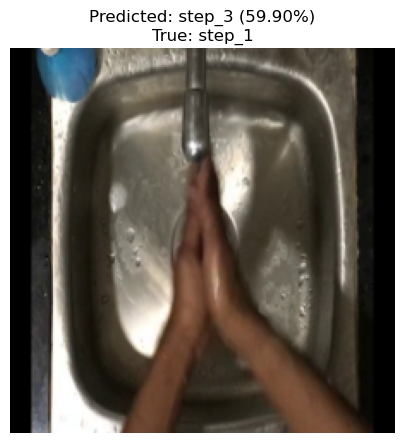

In [47]:
# Call the function to visualize predictions
visualize_model(model_ft, dataloader, class_names)

### Comparisons

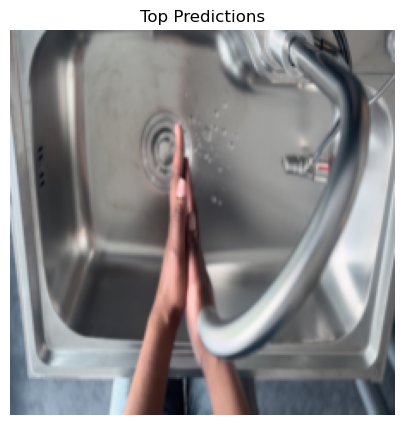

Prediction 1: step_3 - Confidence: 68.65%
Prediction 2: step_1 - Confidence: 15.16%
Prediction 3: step_5_Left - Confidence: 5.49%


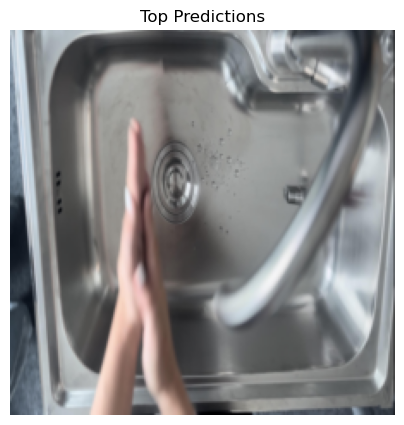

Prediction 1: step_3 - Confidence: 79.86%
Prediction 2: step_1 - Confidence: 11.12%
Prediction 3: step_2_Left - Confidence: 2.62%


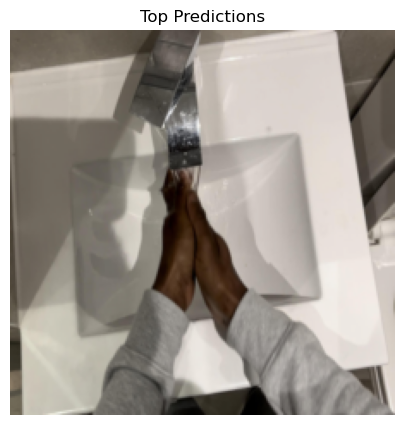

Prediction 1: step_3 - Confidence: 55.08%
Prediction 2: step_6_Left - Confidence: 29.65%
Prediction 3: step_6_Right - Confidence: 4.94%


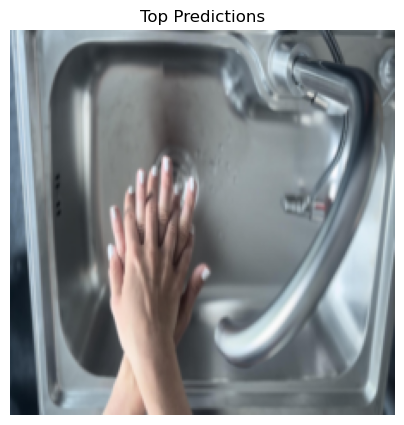

Prediction 1: step_2_Right - Confidence: 58.98%
Prediction 2: step_2_Left - Confidence: 21.19%
Prediction 3: step_5_Right - Confidence: 6.38%


In [48]:
# Test the model on a new image
test_image_path = './processed_dataset/manual_test/1/IMG_3411.jpg'  
predict_single_image_topk(model_ft, test_image_path, class_names, topk=3)

test_image_path1 = './processed_dataset/manual_test/1/1.jpg'  
predict_single_image_topk(model_ft, test_image_path1, class_names, topk=3)

test_image_path2 = './processed_dataset/manual_test/1/2.jpg'  
predict_single_image_topk(model_ft, test_image_path2, class_names, topk=3)

test_image_path3 = './processed_dataset/manual_test/2r/1.jpg'  
predict_single_image_topk(model_ft, test_image_path3, class_names, topk=3)

## Conclusions
MobileNetv2 vs MobileNetv3 Large: v3 Large has better accuracy in validation and higher confidences in manual testing but is more confidently wrong.</br>
MobileNetv2 Fine Tuning vs MobileNetv2 Feature Extraction: Fine tuning has better accuracy in validation and higher confidences in manual testing. Fine Tuning took longer to train and required less epochs as was training more layers. Feature ectraction was faster to train and required more epochs as was training less layers bus accuracy was bad.</br>
MobileNetv Feature Extraction 5 epochs vs MobileNetv Feature Extraction 25 epochs: 25 epochs had a slightly better accuracy in validation and higher confidences in manual testing. 25 epochs took longer to train and even with the higher confidence it was more accuratley bad.
